# Иллюстрация ядерно-обобщённого метода опорных векторов

##### Автор: Виктор Китов ([DeepMachineLearning.ru](https://deepmachinelearning.ru))

##### Лицензия: BSD-3-Clause

В этом ноутбуке рассмотрим зависимости прогнозов ядерно-обобщённого метода опорных векторов от типа ядер, гиперпараметров ядер и силы регуляризации.

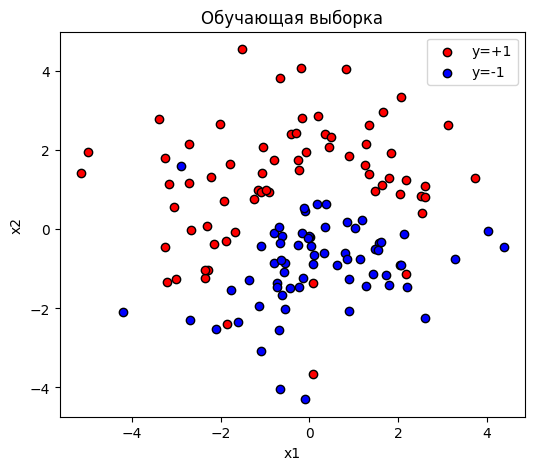

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def generate_sinusoidal_data(
    samples_count=120,
    outliers_proportion=0.1,
    theta=np.pi/6,
    margin=0.3,
    scale=2.0,
    random_state=None
):
    """
    Генерация двумерных данных для двух классов с синусной границей, повёрнутой на theta,
    с удалением точек близко к границе и добавлением выбросов.
    
    Returns
    -------
    X : ndarray, shape=(n_samples, 2)
        Двумерные координаты точек.
    labels : ndarray, shape=(n_samples,)
        Метки классов (+1/-1)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Генерация точек
    X = np.random.normal(loc=0.0, scale=scale, size=(samples_count, 2))
    x, y = X[:,0], X[:,1]

    # Поворот координат для синусной границы
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    x_rot = cos_t*x + sin_t*y
    y_rot = -sin_t*x + cos_t*y

    # граница
    y_boundary = np.cos(x_rot)

    # Определяем классы
    labels = np.where(y_rot > y_boundary, 1, -1)

    # Убираем точки слишком близко к границе
    distance_to_boundary = np.abs(y_rot - y_boundary)
    mask_far = distance_to_boundary > margin
    X = X[mask_far]
    labels = labels[mask_far]

    # Добавляем выбросы
    n_outliers = int(len(labels) * outliers_proportion)
    outlier_indices = np.random.choice(len(labels), n_outliers, replace=False)
    labels[outlier_indices] *= -1

    return X, labels

# --- Генерация данных ---
X, labels = generate_sinusoidal_data(
    samples_count=150,
    outliers_proportion=0.04,
    theta=np.pi/10,
    margin=0.3,
    scale=1.8,
    random_state=5
)

#X+=6
# --- Визуализация ---
plt.figure(figsize=(6,5))
plt.scatter(X[labels==1,0], X[labels==1,1], color='red', edgecolor='k', label='y=+1')
plt.scatter(X[labels==-1,0], X[labels==-1,1], color='blue', edgecolor='k', label='y=-1')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Обучающая выборка')
plt.legend()
plt.show()


In [2]:
def plot_2d_classifiers_decision_boundary(
    X,                    # Обучающие данные (n_samples, 2)
    y,                    # Метки классов (+1/-1)
    classifiers_lst,      # Список обученных классификаторов (sklearn)
    titles_lst,           # Заголовки для каждого subplot
    vis_points_count=200, # Плотность сетки для предсказаний
    size=6,               # Диапазон сетки: [-size, size] по каждой оси
    axes_size=(1,1),      # Сетка subplot (n_rows, n_cols)
    figsize=(12,8)        # Размер фигуры
):
    """
    Визуализирует разбиение пространства признаков классификаторами.
    Для каждого классификатора строится subplot:
    - Поле с прогнозами (красный - положительный класс, синий - отрицательный)
    - Scatter обучающих точек поверх прогноза
    """
    n_rows, n_cols = axes_size
    total_axes = n_rows * n_cols

    if len(classifiers_lst) != len(titles_lst):
        raise ValueError("Длины classifiers_lst и titles_lst должны совпадать.")
    if len(classifiers_lst) > total_axes:
        raise ValueError("axes_size содержит меньше осей, чем требуется.")

    # Создание сетки для прогнозов
    xx1 = np.linspace(-size, size, vis_points_count)
    xx2 = np.linspace(-size, size, vis_points_count)
    XX1, XX2 = np.meshgrid(xx1, xx2)
    grid_points = np.c_[XX1.ravel(), XX2.ravel()]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for i, (clf, title) in enumerate(zip(classifiers_lst, titles_lst)):
        ax = axes_flat[i]

        # Предсказания на сетке
        y_pred_grid = clf.predict(grid_points)
        # Убедимся, что классы +1/-1 (для корректного окрашивания)
        y_pred_grid = np.where(y_pred_grid > 0, 1, -1)
        y_pred_grid = y_pred_grid.reshape(XX1.shape)

        # Отображаем прогнозы: красный - +1, синий - -1
        ax.contourf(XX1, XX2, y_pred_grid, alpha=0.3, levels=[-1,0,1], colors=['blue','red'])

        # Scatter обучающих точек
        ax.scatter(X[y==1,0], X[y==1,1], color='red', edgecolor='k', label='y=+1')
        ax.scatter(X[y==-1,0], X[y==-1,1], color='blue', edgecolor='k', label='y=-1')

        ax.set_xlim(-size, size)
        ax.set_ylim(-size, size)
        ax.set_aspect('equal', adjustable='box')  # одинаковый масштаб по осям
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        
        
        ax.legend()

    # Выключаем лишние оси
    for j in range(len(classifiers_lst), total_axes):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()


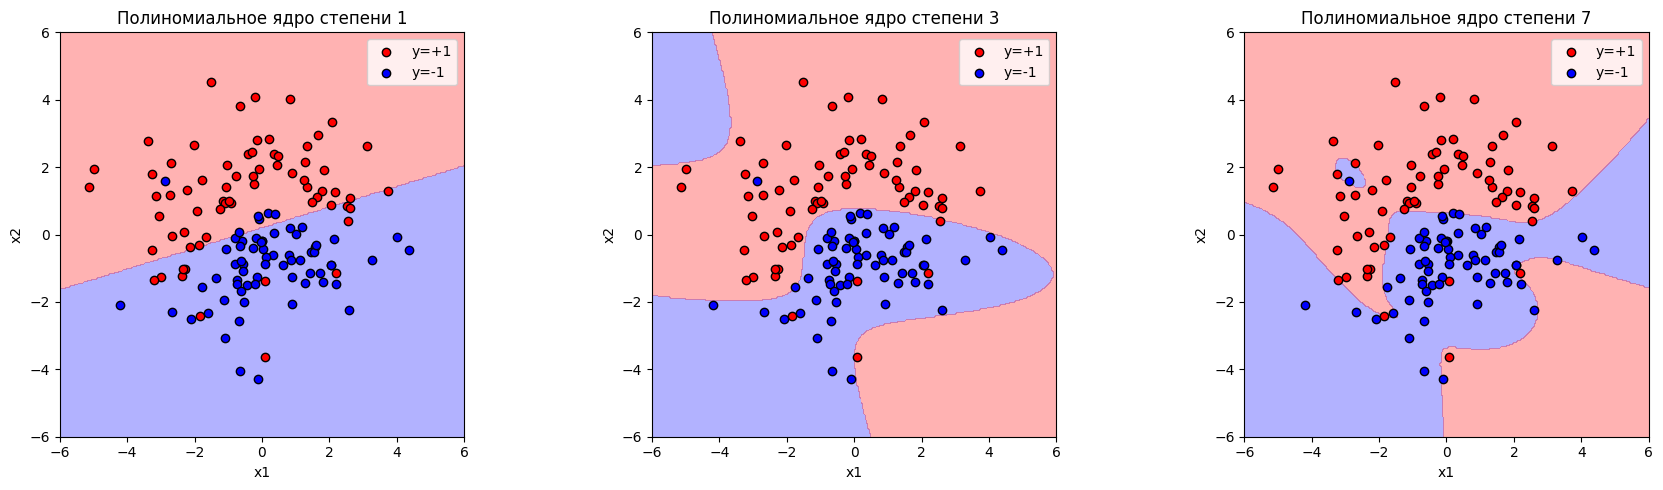

In [3]:
# Значения степени полинома
degrees = [1, 3, 7]
C_val = 1  # фиксированное значение C

# Создание классификаторов с полиномиальным ядром
classifiers_poly = [SVC(kernel='poly', degree=d, coef0=10, C=1000).fit(X, labels) for d in degrees]

# Заголовки графиков
titles_poly = [f'Полиномиальное ядро степени {d}' for d in degrees]

# Визуализация
plot_2d_classifiers_decision_boundary(
    X, labels,
    classifiers_lst=classifiers_poly,
    titles_lst=titles_poly,
    vis_points_count=300,
    size=6,
    axes_size=(1,3),
    figsize=(18,5)
)

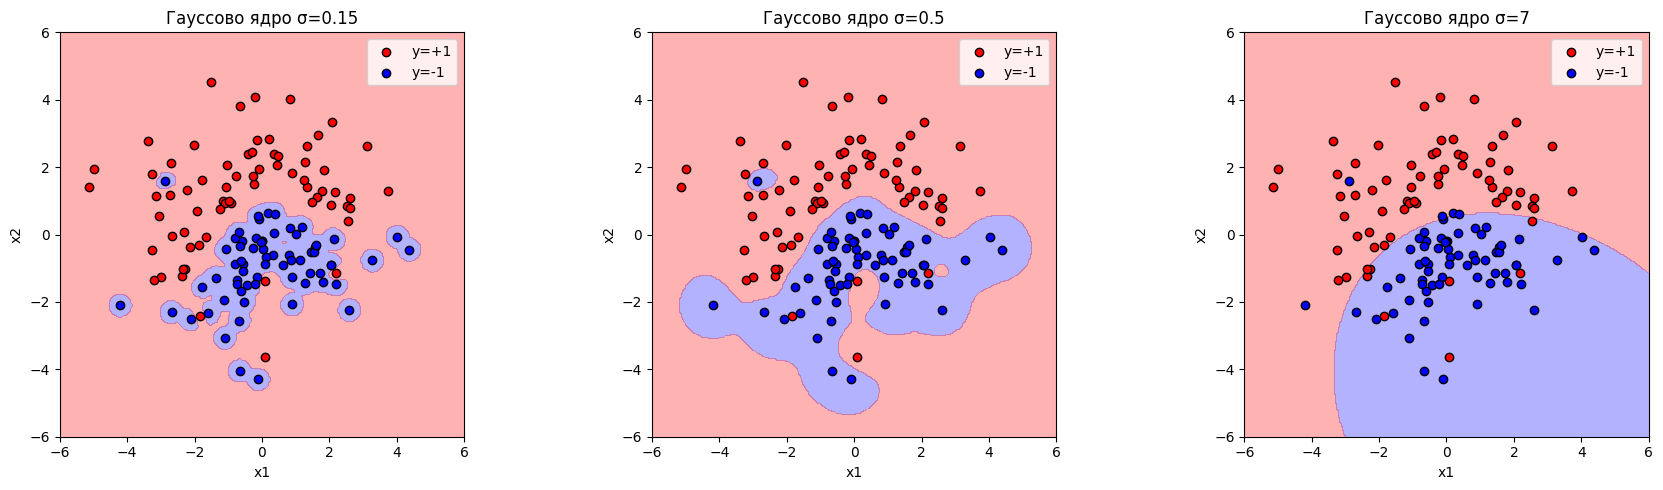

In [4]:
sigma_values = [0.15, 0.5, 7]  # желаемые ширины Гауссова ядра
C_val = 100

classifiers_rbf_sigma = [
    SVC(kernel='rbf', gamma=1/(2*s**2), C=10).fit(X, labels)
    for s in sigma_values
]

titles_rbf_sigma = [f'Гауссово ядро σ={s}' for s in sigma_values]

# Визуализация
plot_2d_classifiers_decision_boundary(
    X, labels,
    classifiers_lst=classifiers_rbf_sigma,
    titles_lst=titles_rbf_sigma,
    vis_points_count=300,
    size=6,
    axes_size=(1,3),
    figsize=(18,5)
)


# Влияние силы регуляризации

## Линейное ядро

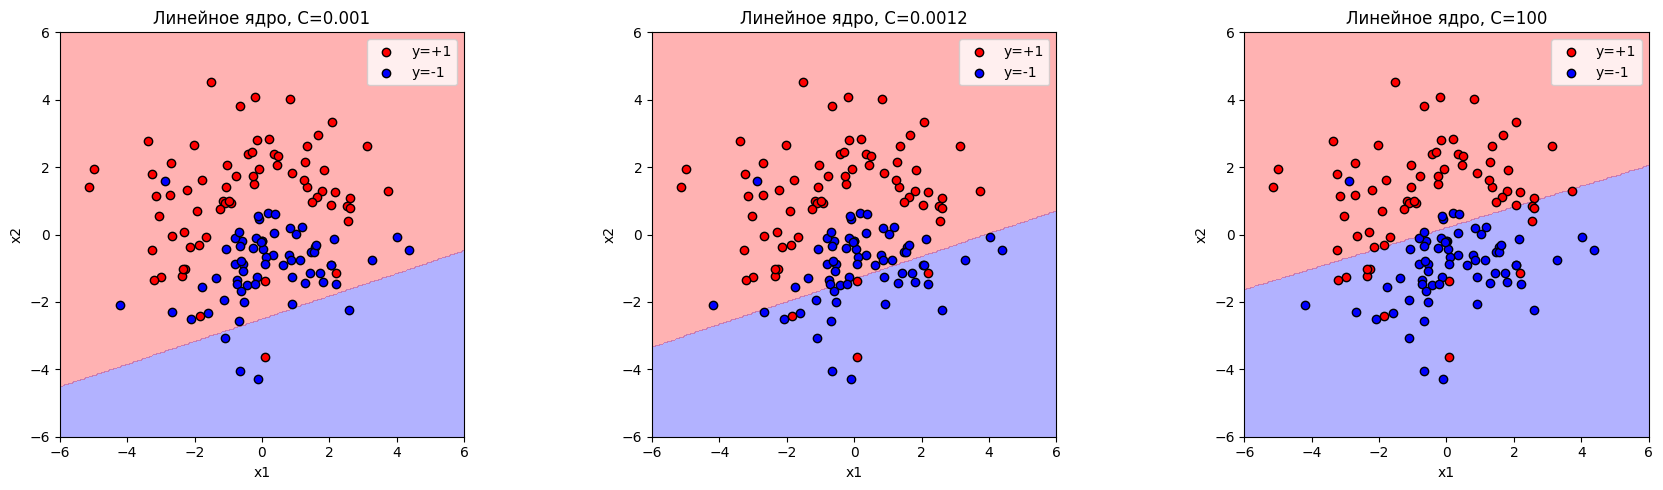

In [27]:
# Значения параметра регуляризации C
C_values = [0.001, 0.0012, 100]

# Создание классификаторов с линейным ядром
classifiers_linear = [SVC(kernel='linear', C=C_val).fit(X, labels) for C_val in C_values]

# Заголовки графиков
titles_linear = [f'Линейное ядро, C={C_val}' for C_val in C_values]

# Визуализация
plot_2d_classifiers_decision_boundary(
    X, labels,
    classifiers_lst=classifiers_linear,
    titles_lst=titles_linear,
    vis_points_count=300,
    size=6,
    axes_size=(1,3),
    figsize=(18,5)
)

## Полиномиальное ядро

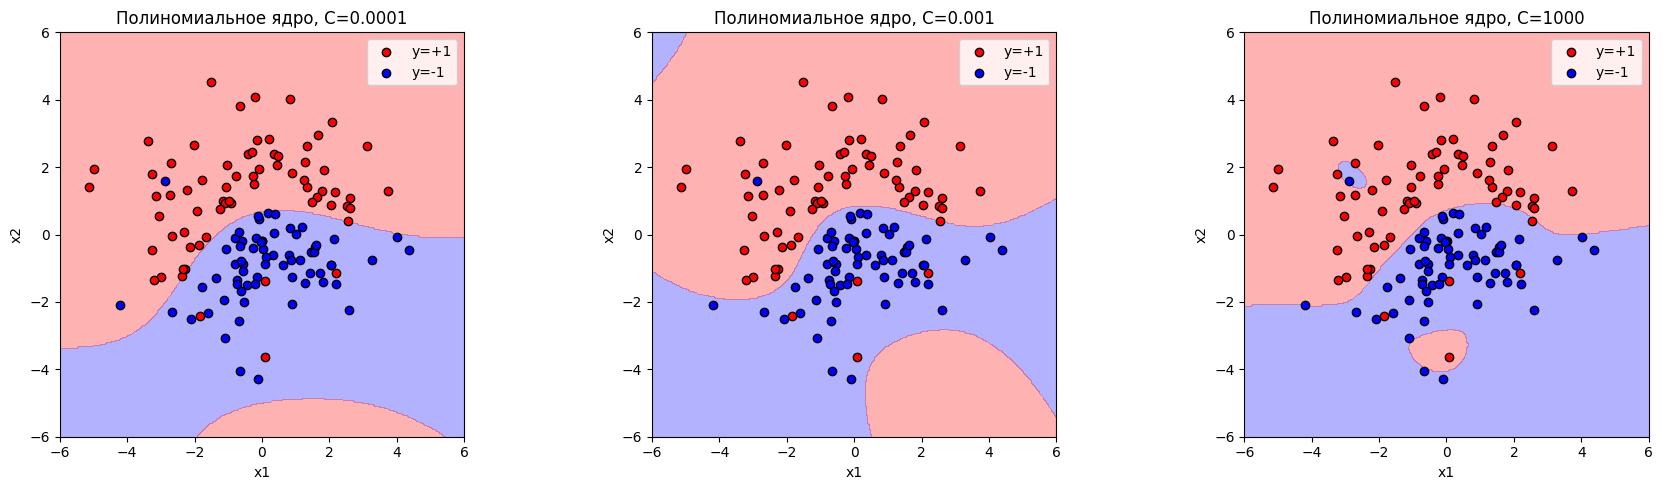

In [26]:
# Значения параметра регуляризации C
C_values_poly = [0.0001, 0.001, 1000]

# Классификаторы: полиномиальное ядро степени 3
classifiers_poly_C = [
    SVC(kernel='poly', degree=5, coef0=10, C=C_val).fit(X, labels)
    for C_val in C_values_poly
]

# Заголовки
titles_poly_C = [f'Полиномиальное ядро, C={C_val}' for C_val in C_values_poly]

# Визуализация
plot_2d_classifiers_decision_boundary(
    X, labels,
    classifiers_lst=classifiers_poly_C,
    titles_lst=titles_poly_C,
    vis_points_count=300,
    size=6,
    axes_size=(1, 3),
    figsize=(18, 5)
)


## Гауссово ядро

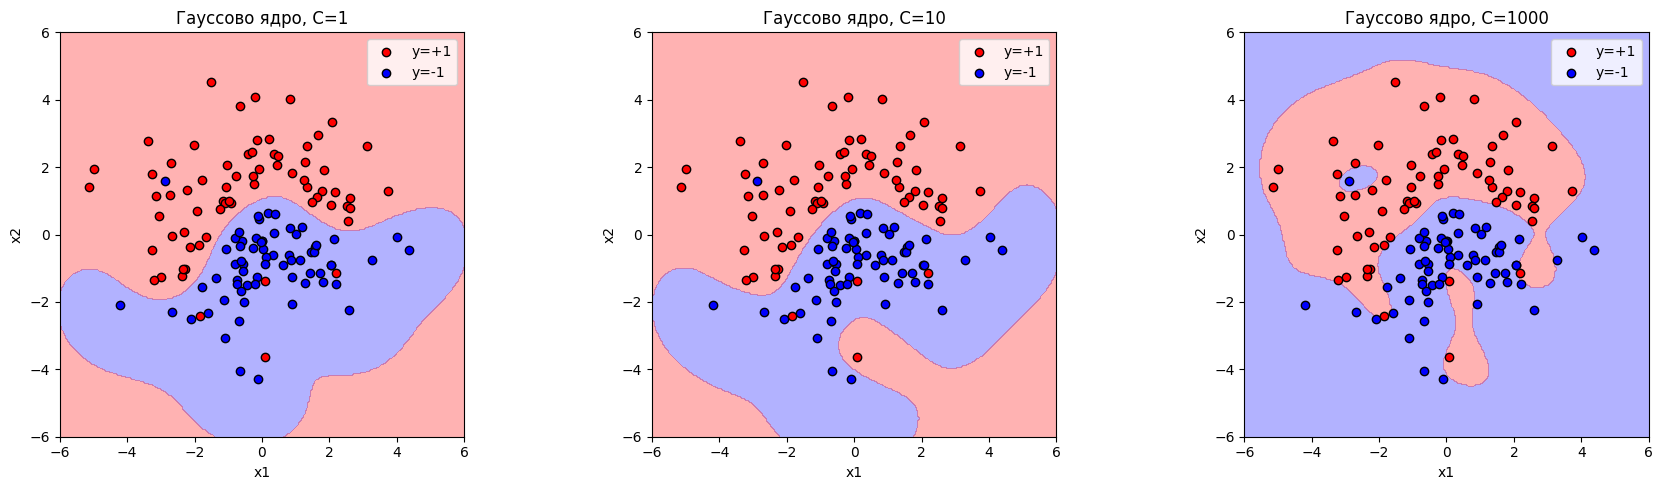

In [30]:
# Значения параметра регуляризации C
C_values_rbf = [1, 10, 1000]

sigma = 1
gamma_val = 1 / (2 * sigma**2)

# Классификаторы: RBF-ядро
classifiers_rbf_C = [
    SVC(kernel='rbf', gamma=gamma_val, C=C_val).fit(X, labels)
    for C_val in C_values_rbf
]

# Заголовки
titles_rbf_C = [f'Гауссово ядро, C={C_val}' for C_val in C_values_rbf]

# Визуализация
plot_2d_classifiers_decision_boundary(
    X, labels,
    classifiers_lst=classifiers_rbf_C,
    titles_lst=titles_rbf_C,
    vis_points_count=300,
    size=6,
    axes_size=(1, 3),
    figsize=(18, 5)
)
